
--- Generating Raag Bhairav Melody using Enhanced SA ---

Run 1/5
🎵 Initial melody saved as 'bhairav_initial_melody_run1.mid' in 'Music'
m P d G m# N S' G# s r# d r G d S' r# r# S' G m# S' r r S' m r m P r# s G m G r# r# S' m# N m G G# S' s S' P P N S' m# d# G# d S' G d# G# S' G# m d r# G# r r# S' S' G# S' d# d# G d# d G s d# G d d# d r# d m# S' r# r# s r# d# N G s m# G N G# r# N S' P
Final cost: -770.00

Run 2/5
🎵 Initial melody saved as 'bhairav_initial_melody_run2.mid' in 'Music'
m d m m G m G r# N d# r# d# s S' m s S' s m# S' G# G r G# G# m# s s s G# d# r G# G# S' r s d# m# N m# G# s G r# r# m G# d P m m N d# m# G r G# r s r# m r r P r m N s G d m m s d r s G# G P d s s N r G m r s s S' d r d G# G# r r# r s
Final cost: -770.00

Run 3/5
🎵 Initial melody saved as 'bhairav_initial_melody_run3.mid' in 'Music'
G# d# S' r s m m N m# d# r# d# m# P d m r r# S' d# G P P m m S' d d# m# G d P P d# G P P m# s S' S' P P m d# d m# m# r# G G S' d d# G# d s N m# G m# P G# G# S' s P S' m# G# s G# 

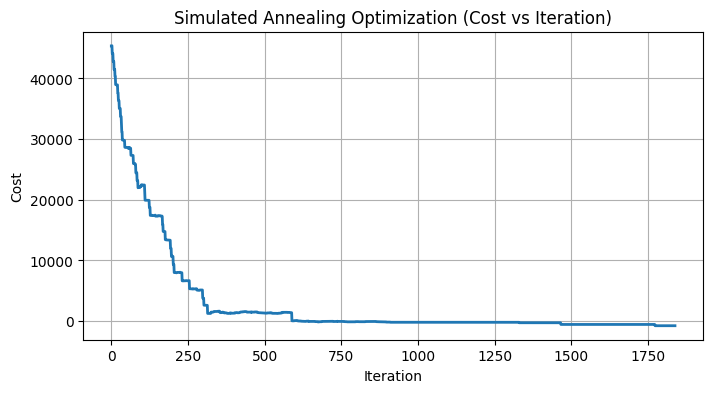


🎵 Optimized melody saved as 'bhairav_melody_enhanced.mid' in 'Music'


In [ ]:
import random
import math
import os
import matplotlib.pyplot as plt
from midiutil import MIDIFile

OUTPUT_FOLDER = "Music"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# 1. Raag Bhairav Definition
RAAG_BHAIRAV_SWARAS = ['s', 'r', 'G', 'm', 'P', 'd', 'N', "S'"]
NOTE_PITCH_MAP = {'s':0, 'r':1, 'G':4, 'm':5, 'P':7, 'd':8, 'N':11, "S'":12}
MIDI_PITCH_MAP = {note: 60 + semitone for note, semitone in NOTE_PITCH_MAP.items()}
AROHA = ['s', 'r', 'G', 'm', 'P', 'd', 'N', "S'"]
AVAROHA = ["S'", 'N', 'd', 'P', 'm', 'G', 'r', 's']
VADI_SWAR = 'd'
SAMVADI_SWAR = 'r'
PAKAD_PHRASES = [
    ('G', 'm', 'd', 'P'),
    ('G', 'm', 'r', 's'),
    ('m', 'P', 'd', 'm', 'P', 'G', 'm', 'r'),
    ('d', 'N', "S'")
]

# Cost Functions
def calculate_cost(melody):
    W_INVALID_NOTE, W_VADI_SAMVADI = 1000, 15
    W_PAKAD, W_CONTOUR, W_AROHA_AVAROHA = 70, 2, 30
    total = 0
    total += W_INVALID_NOTE * cost_invalid_notes(melody)
    total += W_VADI_SAMVADI * cost_vadi_samvadi(melody)
    total -= W_PAKAD * reward_pakad_phrases(melody)
    total += W_CONTOUR * cost_melodic_contour(melody)
    total += W_AROHA_AVAROHA * cost_aroh_avroh_transitions(melody)
    return total

def cost_invalid_notes(melody):
    return sum(1 for note in melody if note not in RAAG_BHAIRAV_SWARAS)

def cost_vadi_samvadi(melody):
    min_required = 4
    return max(0, min_required - (melody.count(VADI_SWAR) + melody.count(SAMVADI_SWAR)))

def reward_pakad_phrases(melody):
    melody_str = " ".join(melody)
    return sum(len(phrase) for phrase in PAKAD_PHRASES if " ".join(phrase) in melody_str)

def cost_melodic_contour(melody):
    penalty = 0
    for i in range(len(melody)-1):
        n1, n2 = melody[i], melody[i+1]
        if n1 not in NOTE_PITCH_MAP or n2 not in NOTE_PITCH_MAP:
            penalty += 10  # assign penalty for invalid note jumps
            continue
        jump = abs(NOTE_PITCH_MAP[n1] - NOTE_PITCH_MAP[n2])
        if jump > 7:
            penalty += (jump - 7)**2
    return penalty

def cost_aroh_avroh_transitions(melody):
    penalty = 0
    for i in range(len(melody)-1):
        n1, n2 = melody[i], melody[i+1]
        if n1 not in NOTE_PITCH_MAP or n2 not in NOTE_PITCH_MAP:
            penalty += 5  # penalty for invalid transitions
            continue
        p1, p2 = NOTE_PITCH_MAP[n1], NOTE_PITCH_MAP[n2]
        if p2 > p1 and n2 not in AROHA:
            penalty += 1
        if p2 < p1 and n2 not in AVAROHA:
            penalty += 1
    return penalty


# Neighbor Generation
def get_neighbor(melody):
    new_melody = melody.copy()
    mutation_type = random.random()
    if mutation_type < 0.7:
        pos = random.randint(0, len(new_melody)-1)
        new_melody[pos] = random.choice(RAAG_BHAIRAV_SWARAS)
    elif mutation_type < 0.9:
        i, j = random.sample(range(len(new_melody)), 2)
        new_melody[i], new_melody[j] = new_melody[j], new_melody[i]
    else:
        start = random.randint(0, len(new_melody)-2)
        end = random.randint(start+1, len(new_melody)-1)
        new_melody[start:end] = list(reversed(new_melody[start:end]))
    return new_melody

# Simulated Annealing
def simulated_annealing(initial_melody, T_init, cooling_rate, T_stop):
    melody = initial_melody
    cost = calculate_cost(melody)
    T = T_init
    costs = [cost]
    while T > T_stop:
        neighbor = get_neighbor(melody)
        new_cost = calculate_cost(neighbor)
        Δ = new_cost - cost
        if Δ < 0 or random.random() < math.exp(-Δ/T):
            melody, cost = neighbor, new_cost
        costs.append(cost)
        T *= cooling_rate
    return melody, cost, costs

# MIDI Output 
def create_midi_file(melody, filename, tempo=120):
    track, channel, time = 0, 0, 0
    MyMIDI = MIDIFile(1)
    MyMIDI.addTempo(track, time, tempo)
    for note in melody:
        if note in MIDI_PITCH_MAP:
            pitch = MIDI_PITCH_MAP[note]
            duration = random.choice([0.5,1,1,1.5,2])
            MyMIDI.addNote(track, channel, pitch, time, duration, 100)
            time += duration
    path = os.path.join(OUTPUT_FOLDER, filename)
    with open(path, "wb") as f:
        MyMIDI.writeFile(f)
    return path

# Experiment Setup
MELODY_LENGTH = 100
INITIAL_TEMP = 1000
COOLING_RATE = 0.995
STOP_TEMP = 0.1
RUNS = 5
best_melody, best_cost = None, float('inf')

print("\n--- Generating Raag Bhairav Melody using Enhanced SA ---")
for run in range(RUNS):
    print(f"\nRun {run+1}/{RUNS}")
    # init_melody = [random.choice(RAAG_BHAIRAV_SWARAS) for _ in range(MELODY_LENGTH)]
    # init_melody = random.sample(RAAG_BHAIRAV_SWARAS * (MELODY_LENGTH // len(RAAG_BHAIRAV_SWARAS) + 1), MELODY_LENGTH)
    init_melody = [random.choice(list(NOTE_PITCH_MAP.keys()) + ['r#', 'G#', 'm#', 'd#']) for _ in range(MELODY_LENGTH)]

    # Save initial melody
    init_file = f"bhairav_initial_melody_run{run+1}.mid"
    create_midi_file(init_melody, init_file)
    print(f"🎵 Initial melody saved as '{init_file}' in '{OUTPUT_FOLDER}'")
    print(" ".join(init_melody))

    melody, cost, cost_track = simulated_annealing(init_melody, INITIAL_TEMP, COOLING_RATE, STOP_TEMP)
    print(f"Final cost: {cost:.2f}")

    if cost < best_cost:
        best_melody, best_cost, best_track = melody, cost, cost_track

# --- Display Results ---
print("\nFinal Optimized Melody:")
print(" ".join(best_melody))
print(f"Best Cost: {best_cost:.2f}")

plt.figure(figsize=(8,4))
plt.plot(best_track, lw=2)
plt.title("Simulated Annealing Optimization (Cost vs Iteration)")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.grid(True)
plt.show()

# Save optimized melody
opt_file = "bhairav_melody_enhanced.mid"
create_midi_file(best_melody, opt_file)
print(f"\n🎵 Optimized melody saved as '{opt_file}' in '{OUTPUT_FOLDER}'")
